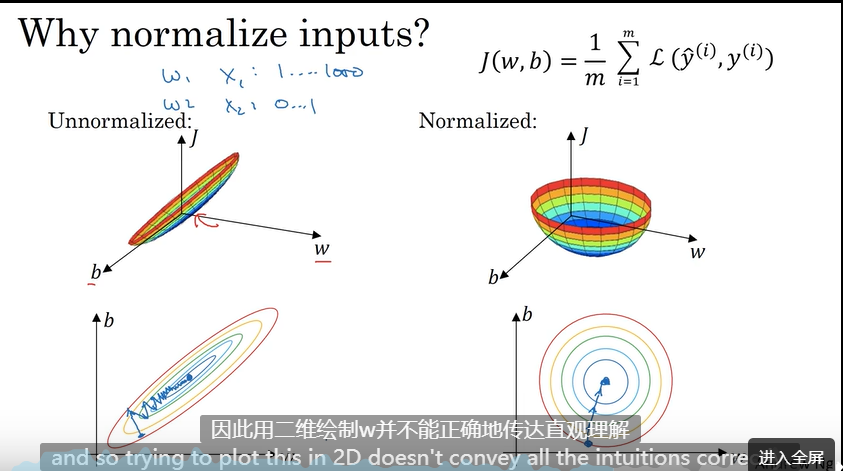

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,Imputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns

import torch.utils.data as Data 


# import EarlyStopping
from pytorchtools import EarlyStopping
  
torch.manual_seed(1) # 设定随机数种子 
batch_size = 128

In [3]:
target_name = 'target'
scores_folds = {}

# data directory
data_dir = 'D:data/optiver/'
train = pd.read_parquet(data_dir+'train.parquet')

In [74]:
train['target'].describe()

count    428932.000000
mean          0.003880
std           0.002936
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070321
Name: target, dtype: float64

* 没有归一化，loss在第二次迭代就出现nan
* 没有batch，内存放不下
* 缺失值问题
* 波动率本来就很小，如果每层激活函数都为relu,预测之后都为0
* 在这个任务中，使用tanh激活函数效果可以，rsmpe达到了0.27


In [8]:
class rsmpe_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return torch.sum(torch.pow((x - y)/y, 2))


cols = [col for col in train.columns if col not in ['stock_id','time_id','target','row_id']]
input_size = len(cols)


# 数据

x_train,x_test,y_train,y_test = train_test_split(train[cols],train['target'],test_size=0.3,random_state=123)
nan_cols = [col for col in train.columns if train[col].isna().any()]

y_test_cnt = y_test.shape[0]
y_train_cnt = y_train.shape[0]

im = Imputer( strategy='mean')
x_train[nan_cols] = im.fit_transform(x_train[nan_cols])
x_test[nan_cols] = im.transform(x_test[nan_cols])

me = MinMaxScaler()
x_train[cols] = me.fit_transform(x_train[cols])
x_test[cols] = me.transform(x_test[cols])

x_train = torch.from_numpy(x_train.values).float()
x_test = torch.from_numpy(x_test.values).float()
y_train = torch.from_numpy(y_train.values).float().view(-1,1) #维度要注意
y_test = torch.from_numpy(y_test.values).float().view(-1,1)



In [55]:
class four_layer_model(nn.Module):
    def __init__(self,input_size):
        super(four_layer_model,self).__init__()
        self.fc1 = nn.Linear(input_size,90)
        self.fc2 = nn.Linear(90,45)
        self.fc3 = nn.Linear(45,20)
        self.fc4 = nn.Linear(20,1)
        self.relu = nn.ReLU()
        self.tan = nn.Tanh()
        self.dropout = nn.Dropout(0.3)
    def forward(self,x):
        x = self.tan(self.fc1(x))
        x = self.dropout(x)
        x = self.tan(self.fc2(x))
        x = self.dropout(x)
        x = self.tan(self.fc3(x))
        x = self.dropout(x)
        out = self.tan(self.fc4(x))
        return out

test_data = x_train[:100]

torch.manual_seed(1)
nn_model = four_layer_model(input_size)
nn_model(test_data)

tensor([[-1.4264e-01],
        [ 8.4507e-02],
        [-5.6330e-02],
        [ 1.1722e-01],
        [-1.4284e-02],
        [ 1.4135e-01],
        [ 4.7240e-02],
        [ 1.4082e-02],
        [ 4.0981e-02],
        [-6.2672e-02],
        [ 7.9788e-02],
        [-1.4267e-02],
        [ 2.2719e-01],
        [ 1.7014e-01],
        [-8.5093e-03],
        [-5.0622e-02],
        [-8.4099e-02],
        [ 8.0299e-02],
        [ 8.8039e-02],
        [ 1.5224e-01],
        [ 1.4372e-01],
        [ 8.5987e-02],
        [-2.8693e-02],
        [-6.5989e-02],
        [ 6.5629e-02],
        [ 2.0793e-01],
        [ 1.5604e-01],
        [ 2.6922e-02],
        [ 1.1540e-01],
        [ 1.4216e-01],
        [ 1.4280e-01],
        [ 1.4445e-02],
        [ 1.4920e-02],
        [ 1.4254e-02],
        [-1.7992e-04],
        [ 8.8581e-03],
        [ 1.4980e-01],
        [ 6.3276e-02],
        [-3.0040e-02],
        [ 9.7582e-02],
        [-5.7447e-02],
        [ 1.1203e-01],
        [ 9.0862e-02],
        [ 1

In [58]:
def train_model(train,train_label,val,val_label,learning_rate=1e-2,num_epochs=5,patience=20):
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    optimizer = torch.optim.Adam(nn_model.parameters(),lr=learning_rate)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    # 损失函数
    criterion = rsmpe_loss()
    torch_dataset = Data.TensorDataset(x_train,y_train) 
    # 将torch_dataset置入Dataloader中 
    loader = Data.DataLoader( 
      dataset=torch_dataset, 
      batch_size=batch_size, # 批大小 
      # 若dataset中的样本数不能被batch_size整除的话，最后剩余多少就使用多少 
      shuffle=True, # 是否随机打乱顺序 
      num_workers=2, # 多线程读取数据的线程数 
      ) 

    torch_val_dataset = Data.TensorDataset(x_test,y_test)
    val_loader = Data.DataLoader( 
      dataset=torch_val_dataset, 
      batch_size=batch_size, # 批大小 
      # 若dataset中的样本数不能被batch_size整除的话，最后剩余多少就使用多少 
      shuffle=True, # 是否随机打乱顺序 
      num_workers=2, # 多线程读取数据的线程数 
      ) 
    # criterion_sum = nn.MSELoss(reduction='sum')
    nn_model.train() # prep model for training
    for epoch in range(1,num_epochs+1):
        # 将数据转换为torch的dataset格式 
        train_loss_sum = 0
        val_loss_sum = 0
        for step, (batch_x, batch_y) in enumerate(loader):
            output = nn_model(batch_x)
            loss = criterion(output,batch_y)
            train_losses.append(loss.item())
#             print(f'epoch[{epoch}/{step}] train loss {train_loss}')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        nn_model.eval() # prep model for evaluation
        for batch_val_x,batch_val_y in val_loader:
            output_val = nn_model(batch_val_x)
            loss = criterion(output_val,batch_val_y)
            valid_losses.append(loss.item())
#         print(f'epoch {epoch} train_rsmpe {np.sqrt(train_loss_sum/y_train_cnt)} valid_rsmpe {np.sqrt(val_loss_sum/y_test_cnt)}')  
        train_loss = np.sqrt(np.sum(train_losses)/y_train_cnt)
        valid_loss = np.sqrt(np.sum(valid_losses)/y_test_cnt)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, nn_model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    nn_model.load_state_dict(torch.load('checkpoint.pt'))

    return  nn_model, avg_train_losses, avg_valid_losses
    

In [59]:
import torch.nn as nn
torch.manual_seed(1)
nn_model = four_layer_model(input_size)
model,avg_train_losses, avg_valid_losses = train_model(x_train,y_train,x_test,y_test,learning_rate=1e-3,num_epochs=10)

[ 1/10] train_loss: 5.76710 valid_loss: 0.30101
Validation loss decreased (inf --> 0.301010).  Saving model ...
[ 2/10] train_loss: 0.25117 valid_loss: 0.24112
Validation loss decreased (0.301010 --> 0.241117).  Saving model ...
[ 3/10] train_loss: 0.27624 valid_loss: 0.24308
EarlyStopping counter: 1 out of 20
[ 4/10] train_loss: 0.26008 valid_loss: 0.25303
EarlyStopping counter: 2 out of 20
[ 5/10] train_loss: 0.26910 valid_loss: 0.24704
EarlyStopping counter: 3 out of 20
[ 6/10] train_loss: 0.25124 valid_loss: 0.24579
EarlyStopping counter: 4 out of 20
[ 7/10] train_loss: 0.25710 valid_loss: 0.28941
EarlyStopping counter: 5 out of 20
[ 8/10] train_loss: 0.25419 valid_loss: 0.26445
EarlyStopping counter: 6 out of 20
[ 9/10] train_loss: 0.25537 valid_loss: 0.24323
EarlyStopping counter: 7 out of 20
[10/10] train_loss: 0.25065 valid_loss: 0.24275
EarlyStopping counter: 8 out of 20


In [61]:
list(zip(model(test_data).detach().numpy(),y_train.numpy()))

[(array([0.00609995], dtype=float32), array([0.00786968], dtype=float32)),
 (array([0.00170277], dtype=float32), array([0.00221331], dtype=float32)),
 (array([0.00354623], dtype=float32), array([0.0031554], dtype=float32)),
 (array([0.01073616], dtype=float32), array([0.01245465], dtype=float32)),
 (array([0.00248198], dtype=float32), array([0.00367748], dtype=float32)),
 (array([0.00216007], dtype=float32), array([0.00183599], dtype=float32)),
 (array([0.0029156], dtype=float32), array([0.00268892], dtype=float32)),
 (array([0.00501066], dtype=float32), array([0.00650113], dtype=float32)),
 (array([0.00126207], dtype=float32), array([0.00148745], dtype=float32)),
 (array([0.00168207], dtype=float32), array([0.00189282], dtype=float32)),
 (array([0.00316786], dtype=float32), array([0.00372663], dtype=float32)),
 (array([0.00234567], dtype=float32), array([0.00174007], dtype=float32)),
 (array([0.00388957], dtype=float32), array([0.00282691], dtype=float32)),
 (array([0.00209393], dtype

In [14]:
model = one_layer_model
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
criterion(seq_model(x_train[:100]),y_train[:100])
# list(seq_model.parameters())

tensor(100., grad_fn=<SumBackward0>)

In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [10]:
criterion??

In [37]:
MinMaxScaler??